In [1]:
# @title ⚙️ Setup
# 7-8 min
!git clone https://github.com/plana93/ARGO_Vision_CODEMOTION_2025.git
!pip install -e ARGO_Vision_CODEMOTION_2025
!pip install "git+https://github.com/plana93/sam2.git"
!pip install -q ipympl ipywidgets

Cloning into 'ARGO_Vision_CODEMOTION_2025'...
remote: Enumerating objects: 288, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 288 (delta 53), reused 28 (delta 13), pack-reused 192 (from 1)
Receiving objects: 100% (288/288), 48.99 MiB | 13.59 MiB/s, done.
Resolving deltas: 100% (159/159), done.
Obtaining file:///content/ARGO_Vision_CODEMOTION_2025
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 38.6 MB/s eta 0:00:00
  Building editable for CODEMOTION_2025 (pyproject.toml) ... done
  Created wheel for CODEMOTION_2025: filename=codemotion_2025-0.1.0-0.editable-py3-none-any.whl size=3911 sha256=260e1a26b35ef07ba9087a1e5f43eefc7fb580fe4

In [2]:
import os

import sys
sys.path.append("../")
sys.path.append("./ARGO_Vision_CODEMOTION_2025")

import torch
from pathlib import Path
import numpy as np
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

from google.colab import output
output.enable_custom_widget_manager()

from codemotion2025.utils.download_image import download_image_from_url
from codemotion2025.utils.sam_utils import show_mask, show_points, show_frame, save_binary_mask, resize_all_to_largest, show_annotation_preview, save_image
from codemotion2025.utils.utils import print_shape

from sam2.sam2_video_predictor import SAM2VideoPredictor
from sam2.build_sam import build_sam2_video_predictor

print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


In [3]:
# @title 🤖 SAM2 Wrapper
class SAM2PredictorWrapper:
    def __init__(self, model_name="sam2-hiera-large"):
        self._predictor = SAM2VideoPredictor.from_pretrained(f"facebook/{model_name}")
        self._folder_dir = None
        self._frame_names = []
        self._inference_state = None

    def init_state(self, folder_dir: str, sort: bool = True):
        self._folder_dir = folder_dir
        self._frame_names = [p for p in os.listdir(folder_dir) if Path(p).suffix.lower() in {".jpg",".jpeg",".png",".bmp"}]
        if sort:
            self._frame_names.sort(key=lambda p: int(Path(p).stem.split("_")[1]))

        resize_all_to_largest(self._folder_dir, self._frame_names)
        self._inference_state = self._predictor.init_state(video_path=self._folder_dir)
        return self

    def reset_state(self):
        self._predictor.reset_state(self._inference_state)
        return self

    def get_img_name(self, idx: int) -> str :
        return self._frame_names[idx]

    def add_points(self, points, labels, obj_id=0, frame_idx=0, show=False):
        points = np.array(points); labels = np.array(labels)
        _, out_obj_ids, out_mask_logits = self._predictor.add_new_points_or_box(
            inference_state=self._inference_state,
            frame_idx=frame_idx,
            obj_id=obj_id,
            points=points,
            labels=labels
        )
        if show:
            show_frame(self._folder_dir, self._frame_names[frame_idx], frame_idx)
            show_points(points, labels, plt.gca())
            show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
        return self

    def add_points_batch(self, points_list, labels_list, obj_ids, frame_idxs, show=False):
        """Aggiunge più insiemi di punti a frame diversi."""
        for pts, lbls, obj_id, f_idx in zip(points_list, labels_list, obj_ids, frame_idxs):
            self.add_points(pts, lbls, obj_id=obj_id, frame_idx=f_idx, show=show)
        return self

    def propagate(self, show_every_n_frames: int = 0, plot=True, save_masks=False):
        video_segments = {}
        for out_frame_idx, out_obj_ids, out_mask_logits in self._predictor.propagate_in_video(self._inference_state):
            video_segments[out_frame_idx] = { out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
                                             for i, out_obj_id in enumerate(out_obj_ids) }

        if show_every_n_frames > 0 and plot:
            plt.close("all")
            for idx in range(0, len(self._frame_names), show_every_n_frames):
                if idx not in video_segments:
                    continue
                show_frame(self._folder_dir, self._frame_names[idx], idx)
                for obj_id, mask in video_segments[idx].items():
                    show_mask(mask, plt.gca(), obj_id=obj_id)

        if save_masks:
            masks_dir = Path(self._folder_dir) / "masks"
            fg_dir = Path(self._folder_dir) / "foreground"
            bg_dir = Path(self._folder_dir) / "background"
            for d in [masks_dir, fg_dir, bg_dir]:
                d.mkdir(parents=True, exist_ok=True)

            for idx in range(0, len(self._frame_names), show_every_n_frames):
                try:
                    frame_path = Path(self._folder_dir) / self._frame_names[idx]
                    img = np.array(Image.open(frame_path).convert("RGB"))

                    for obj_id, mask in video_segments[idx].items():
                        mask = np.squeeze(mask)
                        if mask.ndim > 2:
                            mask = mask[..., 0]

                        mask_bin = (mask > 0.5).astype(np.uint8)
                        mask_3 = np.stack([mask_bin]*3, axis=-1)

                        # Foreground & background
                        fg = img * mask_3
                        bg = img * (1 - mask_3)

                        # Build filenames
                        prefix = f"{str(obj_id)}_{self._frame_names[idx]}"

                        save_image(mask_bin * 255, masks_dir / f"mask_{prefix}.png")
                        save_image(fg, fg_dir / f"fg_{prefix}.png")
                        save_image(bg, bg_dir / f"bg_{prefix}.png")

                except KeyError:
                    continue

        return self

In [8]:
# @title 🤳🏼 Download Image from web or your laptop
# https://www.basketballnetwork.net/.image/ar_16:9%2Cc_fill%2Ccs_srgb%2Cfl_progressive%2Cq_auto:good%2Cw_1200/MTk5NTYxMTU4NTc3ODkwNDA3/stephen-curry.jpg
# https://s.wsj.net/public/resources/images/BN-MG177_2scvA_M_20160124170807.jpg
# https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTxfUtV5OSfHbti9RXhCqYoxlfecrIk7BUE7GdCRTFCzQNmFzfp4KmLRoJZx3n8Mh96G9A&usqp=CAU
# https://media.cnn.com/api/v1/images/stellar/prod/230501084147-02-steph-curry-warriors-kings-043023.jpg?c=16x9&q=h_833,w_1480,c_fill
test_image = download_image_from_url()
if test_image and os.path.exists(test_image):
    print(f"Using image file at: {test_image}")
else:
    print("No valid image file is available.")

Enter the URL of an online image (or leave blank to use Colab upload): https://media.cnn.com/api/v1/images/stellar/prod/230501084147-02-steph-curry-warriors-kings-043023.jpg?c=16x9&q=h_833,w_1480,c_fill
Downloaded and saved image as: downloads/img_0003.jpg
Using image file at: downloads/img_0003.jpg


In [9]:
## CONFIGURATION
path_dataset = Path(test_image).parent
idx_img = 0
frame_offset = 1
num_repetition_first_frame = 1


In [10]:
m = SAM2PredictorWrapper().init_state(str(path_dataset), sort=True)
image_name = m.get_img_name(idx=idx_img)
image_complete_path = Path(path_dataset) / image_name
img = Image.open(image_complete_path).convert("RGB")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sam2_hiera_large.pt:   0%|          | 0.00/898M [00:00<?, ?B/s]

False True


frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 10.09it/s]


In [11]:
# @title

%matplotlib widget

points = []
obj_ids = []
labels = []
l_obj_ids = []

current_points = []

select_positive = True

def onclick(event):
    if event.inaxes == ax_img:  # click dentro l'immagine
        x, y = int(event.xdata), int(event.ydata)
        current_points.append([x, y])
        cmap = plt.get_cmap("tab10")  # choose a colormap
        color = cmap(len(obj_ids))
        ax_img.scatter(x, y, color=color)
        fig.canvas.draw()

def on_toggle(event):
    global select_positive
    select_positive = not select_positive
    mode = "Positive" if select_positive else "Negative"
    print(f"Switched to {mode} point selection.")

def add_obj(event):
    global current_points
    if current_points:
        points.append(current_points.copy())
        obj_ids.append(len(obj_ids) + 1)
        print(f"Oggetto {obj_ids[-1]} salvato con {len(current_points)} punti.")
        current_points = []  # reset buffer for new obj
    else:
        print("Nessun punto selezionato per questo oggetto!")

def on_ok(event):
    """Conferma selezione e stampa risultato finale."""
    if current_points:
        add_obj(None)

    if not points:
        print("Nessun oggetto creato! Seleziona punti e premi Add Obj.")
        return

    print("\n--- RESULTS ---")
    for i, obj in enumerate(points):
        print(f"Obj {obj_ids[i]} -> {obj}")

    fig.canvas.mpl_disconnect(cid_click)
    plt.close(fig)
    print("\n Frame Annotated")
    for i, obj in enumerate(points):
        print(f"Obj {obj_ids[i]} -> {obj}")
        l_obj_ids.append(obj_ids[i])
        labels.append([1]*len(obj))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.subplots_adjust(bottom=0.3)

ax_img = ax
ax_img.imshow(img)
ax_img.set_title("Click on the image to select points.")

ax_ok = plt.axes([0.7, 0.05, 0.1, 0.075])
ax_toggle = plt.axes([0.33, 0.05, 0.2, 0.075])
ax_add_obj = plt.axes([0.12, 0.05, 0.2, 0.075])

btn_ok = Button(ax_ok, 'OK')
btn_toggle = Button(ax_toggle, 'Switch Selection') # negative not used for now
btn_add_obj = Button(ax_add_obj, 'Add Obj')

# Eventi
cid_click = fig.canvas.mpl_connect('button_press_event', onclick)
btn_ok.on_clicked(on_ok)
btn_toggle.on_clicked(on_toggle) # negative not used for now
btn_add_obj.on_clicked(add_obj)

plt.show()






ValueError: Key backend: 'module://ipympl.backend_nbagg' is not a valid value for backend; supported values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template', 'inline']

In [ ]:
frame_idxs = [idx_img] * len(l_obj_ids)
print_shape(points=points, labels=labels, obj_ids=obj_ids, frame_idxs=frame_idxs)

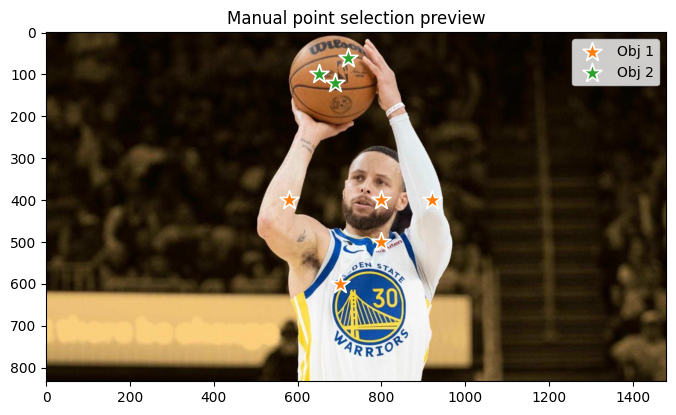

--- Annotation summary ---
Obj 1 -> [[700, 600], [800, 500], [800, 400], [580, 400], [920, 400]]
Obj 2 -> [[650, 100], [690, 120], [720, 60]]


In [32]:
# @title 🧑🏻‍💻 Manual annotation (no interaction)

# --- Define manual points, labels, etc. ---

points = [
    [[700, 600], [800, 500], [800, 400], [580, 400], [920, 400]], # obj 1
    [[650, 100], [690, 120], [720, 60]], # obj 2
]

labels = [
    [1, 1, 1, 1, 1],
    [2, 2, 2]
]

l_obj_ids = [1, 2]
frame_idxs = [idx_img] * len(l_obj_ids)
show_annotation_preview(img, points, l_obj_ids, labels)


propagate in video: 100%|██████████| 4/4 [02:47<00:00, 41.93s/it]


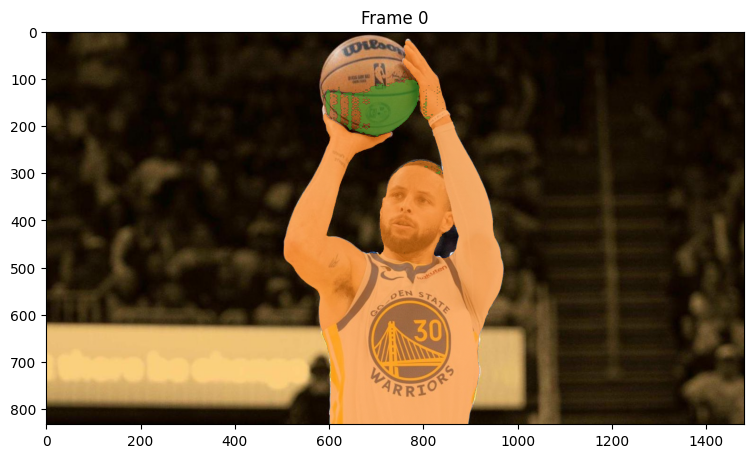

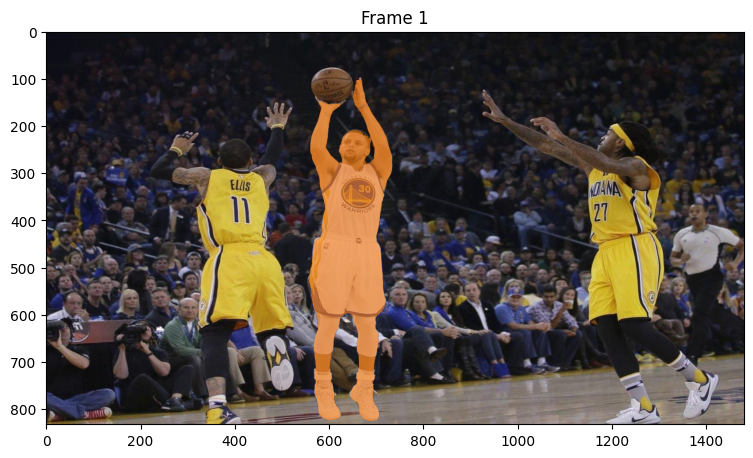

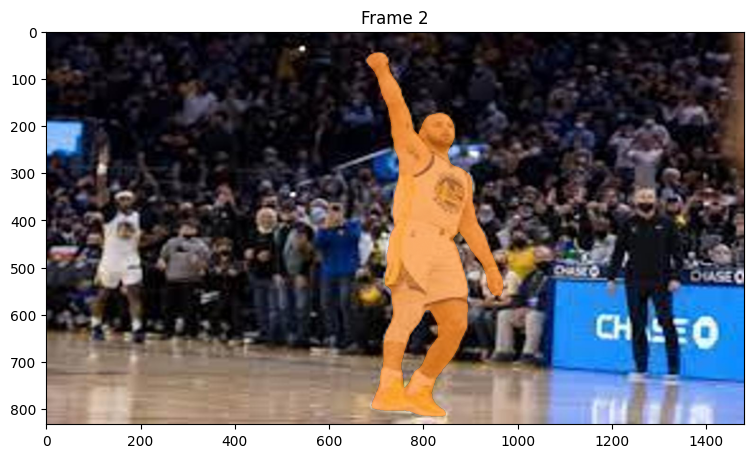

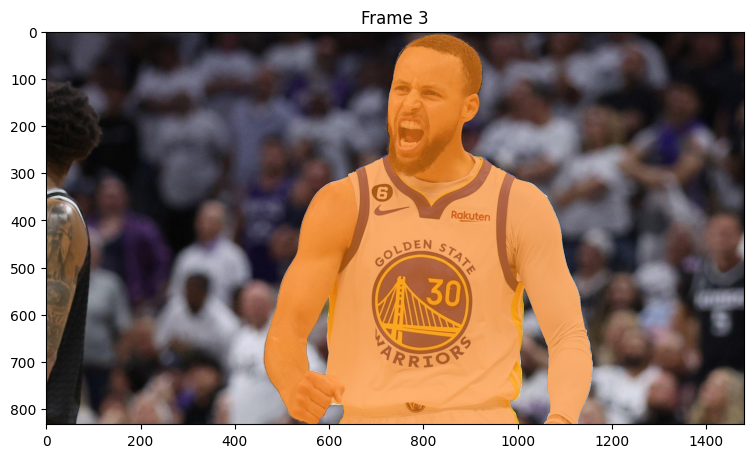

In [33]:
# @title 🎥 Propagation and Prediction
# 5-10 min
# reset the predictor state
m = m.reset_state()

# add initial user points multiple times on the first frame
for _ in range(num_repetition_first_frame):
    m = m.add_points_batch(
        points_list=points,
        labels_list=labels,
        obj_ids=l_obj_ids,
        frame_idxs=[idx_img] * len(l_obj_ids),
        show=False,
    )

# propagate segmentation across the images
m = m.propagate(show_every_n_frames=frame_offset, plot=True, save_masks=True)

In [ ]:
# @title 💾 Save the output on your drive

from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')
output_folder = "/content/downloads"

# Define the destination path in your Google Drive
# You can change 'My Drive/output_sam2' to your desired location
destination_path = '/content/drive/My Drive/output_sam2'
os.makedirs(destination_path, exist_ok=True)
try:
    shutil.copytree(output_folder, destination_path, dirs_exist_ok=True)
    print(f"Successfully copied '{output_folder}' to '{destination_path}'")
except Exception as e:
    print(f"Error copying folder: {e}")